In [57]:
import pandas as pd
import numpy as np
from scalecast.Forecaster import Forecaster
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(14,7)})

# Data preparation

In [58]:
#load data
data = pd.read_csv("..\..\Data\Day\S&P 500 Historical Data00-20.csv")

In [59]:
#transform data
data = data.replace(",", "", regex=True)
data.Date = pd.to_datetime(data.Date)
data = data.sort_values(by=["Date"])
data.set_index('Date')
data.Price = data.Price.astype(float)
data.High = data.High.astype(float)
data.Low = data.Low.astype(float)
data.Open = data.Open.astype(float)
data["Vol."] = data["Vol."].astype(float)

In [60]:
data.index = data.index[::-1]

In [61]:
data.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            4990, 4991, 4992, 4993, 4994, 4995, 4996, 4997, 4998, 4999],
           dtype='int64', length=5000)

In [62]:
# Попробуем вариант что у нас ежедневный прогноз считаем что у нас на выходных стабильная цена.
for i in data.index:
    if i > 0:
        data

In [63]:
special_data = data[(data['Date'] > '2010-01-01') & (data['Date'] < '2014-01-01')]
special_data.index = data.index[:len(special_data)]

In [64]:
#change indexes
special_data.set_index('Date', inplace = True)

In [65]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2000-01-03,1455.2,1469.2,1478.0,1438.4,NaN,-0.95%
1,2000-01-04,1399.4,1455.2,1455.2,1397.4,NaN,-3.83%
2,2000-01-05,1402.1,1399.4,1413.3,1377.7,NaN,0.19%
3,2000-01-06,1403.5,1402.1,1411.9,1392.0,NaN,0.10%
4,2000-01-07,1441.5,1403.5,1441.5,1400.5,NaN,2.71%


In [66]:
special_data.head(10)

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2010-01-04,1132.99,1116.56,1133.87,1116.56,NaN,1.60%
2010-01-05,1136.52,1132.66,1136.63,1129.66,NaN,0.31%
2010-01-06,1137.14,1135.71,1139.19,1133.95,NaN,0.05%
2010-01-07,1141.69,1136.27,1142.46,1131.32,NaN,0.40%
2010-01-08,1144.98,1140.52,1145.39,1136.22,NaN,0.29%
2010-01-11,1146.98,1145.96,1149.74,1142.02,NaN,0.17%
2010-01-12,1136.22,1143.81,1143.81,1131.77,NaN,-0.94%
2010-01-13,1145.68,1137.31,1148.40,1133.18,NaN,0.83%
2010-01-14,1148.46,1145.68,1150.41,1143.80,NaN,0.24%


In [67]:
special_data['new_index'] = special_data.Price
special_data['new_date'] = special_data.Price
special_data.head()

,Price,Open,High,Low,Vol.,Change %,new_index,new_date
Date,,,,,,,,
2010-01-04,1132.99,1116.56,1133.87,1116.56,NaN,1.60%,1132.99,1132.99
2010-01-05,1136.52,1132.66,1136.63,1129.66,NaN,0.31%,1136.52,1136.52
2010-01-06,1137.14,1135.71,1139.19,1133.95,NaN,0.05%,1137.14,1137.14
2010-01-07,1141.69,1136.27,1142.46,1131.32,NaN,0.40%,1141.69,1141.69
2010-01-08,1144.98,1140.52,1145.39,1136.22,NaN,0.29%,1144.98,1144.98


In [68]:
import datetime

special_data.loc[0, 'new_index'] = 1262563200
special_data.loc[0, 'new_date'] = datetime.datetime.fromtimestamp(special_data.loc[0, 'new_index']).strftime('%Y-%m-%d %H:%M:%S')
for i in range(len(special_data.new_index)):
    if i > 0:
        special_data.loc[i, 'new_index'] = special_data.new_index[i - 1] + 86400
        special_data.loc[i, 'new_date'] = datetime.datetime.fromtimestamp(special_data.loc[i, 'new_index']).strftime('%Y-%m-%d %H:%M:%S')

In [69]:
#change indexes
special_data.set_index('new_date', inplace=True)

In [70]:
special_data

,Price,Open,High,Low,Vol.,Change %,new_index
new_date,,,,,,,
2010-01-04 07:00:00,1132.99,1116.56,1133.87,1116.56,NaN,1.60%,1.262563e+09
2010-01-05 07:00:00,1136.52,1132.66,1136.63,1129.66,NaN,0.31%,1.262650e+09
2010-01-06 07:00:00,1137.14,1135.71,1139.19,1133.95,NaN,0.05%,1.262736e+09
2010-01-07 07:00:00,1141.69,1136.27,1142.46,1131.32,NaN,0.40%,1.262822e+09
2010-01-08 07:00:00,1144.98,1140.52,1145.39,1136.22,NaN,0.29%,1.262909e+09
...,...,...,...,...,...,...,...
2012-10-01 07:00:00,1833.32,1828.02,1833.32,1828.02,NaN,0.29%,1.349050e+09
2012-10-02 07:00:00,1842.02,1834.96,1842.84,1834.96,NaN,0.47%,1.349136e+09
2012-10-03 07:00:00,1841.40,1842.97,1844.89,1839.81,NaN,-0.03%,1.349222e+09


In [71]:
# Create a DatetimeIndex with a specific frequency
start_date = '2010-01-04'
end_date = '2012-10-05'
freq = 'D'  # Monthly frequency

date_rng = pd.date_range(start=start_date, end=end_date, freq=freq)

In [72]:
date_rng

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-09', '2010-01-10', '2010-01-11',
               '2010-01-12', '2010-01-13',
               ...
               '2012-09-26', '2012-09-27', '2012-09-28', '2012-09-29',
               '2012-09-30', '2012-10-01', '2012-10-02', '2012-10-03',
               '2012-10-04', '2012-10-05'],
              dtype='datetime64[ns]', length=1006, freq='D')

In [73]:
special_data.head(20)

,Price,Open,High,Low,Vol.,Change %,new_index
new_date,,,,,,,
2010-01-04 07:00:00,1132.99,1116.56,1133.87,1116.56,NaN,1.60%,1.262563e+09
2010-01-05 07:00:00,1136.52,1132.66,1136.63,1129.66,NaN,0.31%,1.262650e+09
2010-01-06 07:00:00,1137.14,1135.71,1139.19,1133.95,NaN,0.05%,1.262736e+09
2010-01-07 07:00:00,1141.69,1136.27,1142.46,1131.32,NaN,0.40%,1.262822e+09
2010-01-08 07:00:00,1144.98,1140.52,1145.39,1136.22,NaN,0.29%,1.262909e+09
2010-01-09 07:00:00,1146.98,1145.96,1149.74,1142.02,NaN,0.17%,1.262995e+09
2010-01-10 07:00:00,1136.22,1143.81,1143.81,1131.77,NaN,-0.94%,1.263082e+09
2010-01-11 07:00:00,1145.68,1137.31,1148.40,1133.18,NaN,0.83%,1.263168e+09
2010-01-12 07:00:00,1148.46,1145.68,1150.41,1143.80,NaN,0.24%,1.263254e+09


In [74]:
print(special_data.index.inferred_freq)

AttributeError: 'Index' object has no attribute 'inferred_freq'

In [75]:
print(date_rng.inferred_freq)

D


In [76]:
#special_data.set_index('new_index', inplace = True)

In [77]:
special_data.head(20)

,Price,Open,High,Low,Vol.,Change %,new_index
new_date,,,,,,,
2010-01-04 07:00:00,1132.99,1116.56,1133.87,1116.56,NaN,1.60%,1.262563e+09
2010-01-05 07:00:00,1136.52,1132.66,1136.63,1129.66,NaN,0.31%,1.262650e+09
2010-01-06 07:00:00,1137.14,1135.71,1139.19,1133.95,NaN,0.05%,1.262736e+09
2010-01-07 07:00:00,1141.69,1136.27,1142.46,1131.32,NaN,0.40%,1.262822e+09
2010-01-08 07:00:00,1144.98,1140.52,1145.39,1136.22,NaN,0.29%,1.262909e+09
2010-01-09 07:00:00,1146.98,1145.96,1149.74,1142.02,NaN,0.17%,1.262995e+09
2010-01-10 07:00:00,1136.22,1143.81,1143.81,1131.77,NaN,-0.94%,1.263082e+09
2010-01-11 07:00:00,1145.68,1137.31,1148.40,1133.18,NaN,0.83%,1.263168e+09
2010-01-12 07:00:00,1148.46,1145.68,1150.41,1143.80,NaN,0.24%,1.263254e+09


In [78]:
f = Forecaster(y = special_data['Price'], current_dates = date_rng)

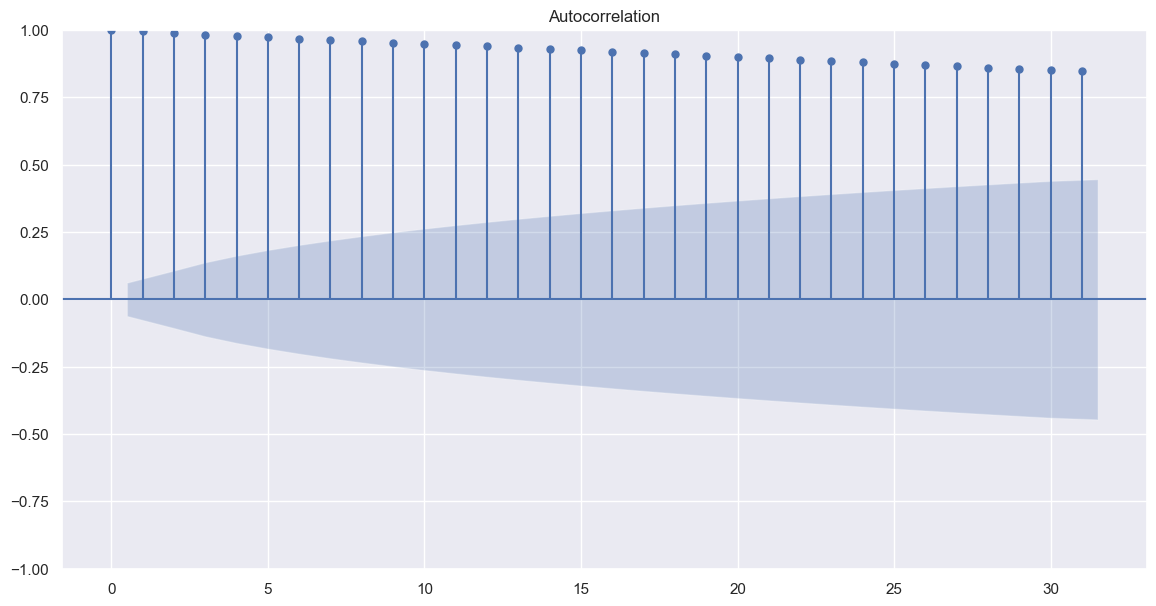

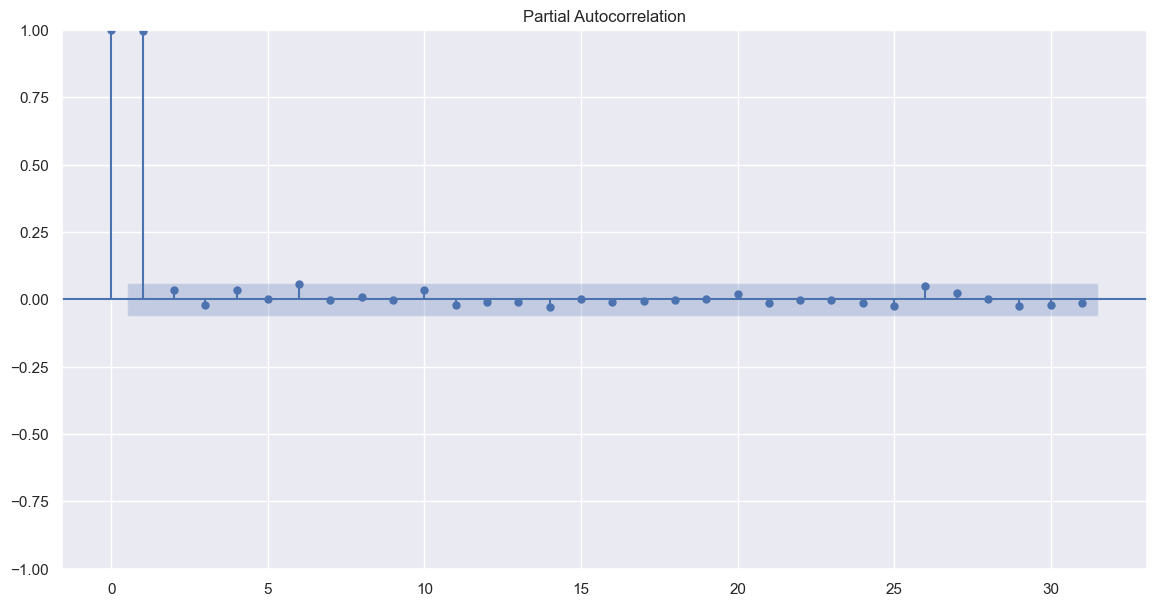

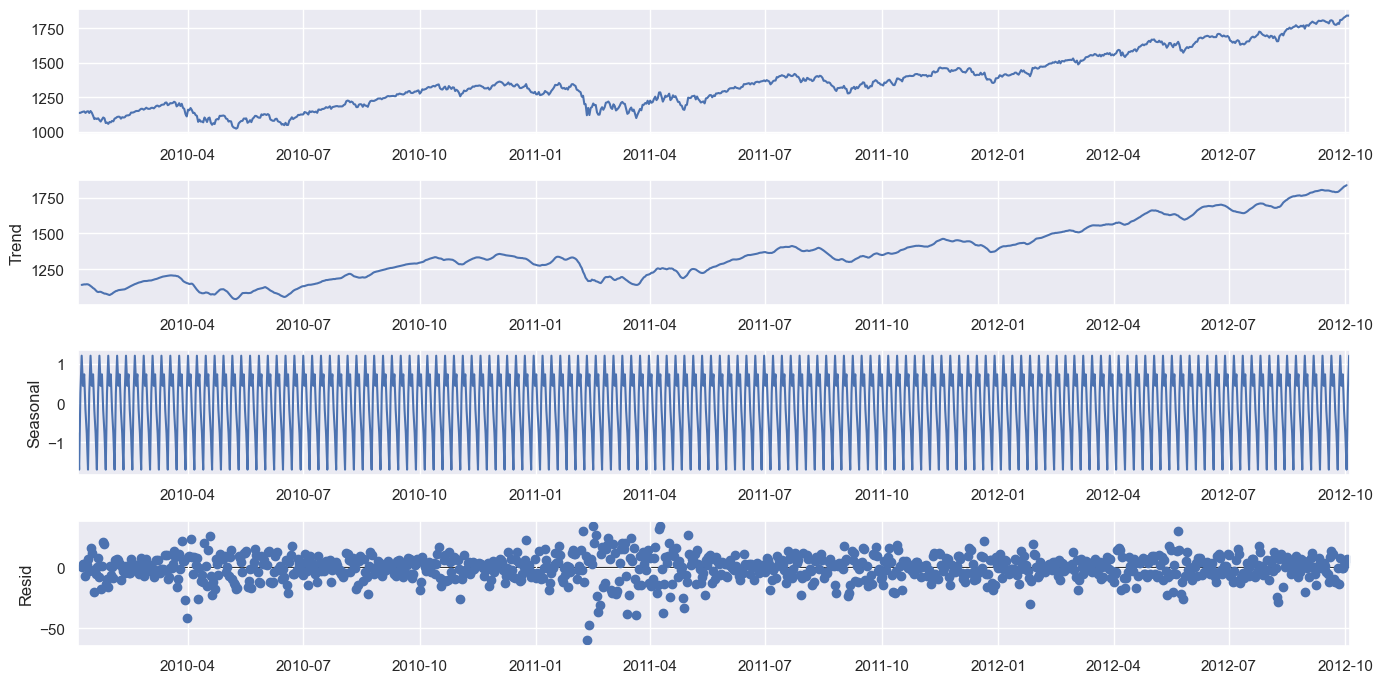

0.502474321545715
0.9849481076057242


In [79]:
# EDA
f.plot_acf()
plt.show()
f.plot_pacf()
plt.show()
f.seasonal_decompose().plot()
plt.show()
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print(stat)
print(pval)

# Data fixing

In [80]:

for_rediff = special_data['Price'][0]
special_data_diff = special_data['Price'].diff()

In [81]:
special_data_diff

new_date
2010-01-04 07:00:00     NaN
2010-01-05 07:00:00    3.53
2010-01-06 07:00:00    0.62
2010-01-07 07:00:00    4.55
2010-01-08 07:00:00    3.29
                       ... 
2012-10-01 07:00:00    5.33
2012-10-02 07:00:00    8.70
2012-10-03 07:00:00   -0.62
2012-10-04 07:00:00   -0.33
2012-10-05 07:00:00    7.29
Name: Price, Length: 1006, dtype: float64

In [82]:
special_data_diff = special_data_diff.loc[special_data_diff.index[1:]]

In [83]:
special_data_diff

new_date
2010-01-05 07:00:00    3.53
2010-01-06 07:00:00    0.62
2010-01-07 07:00:00    4.55
2010-01-08 07:00:00    3.29
2010-01-09 07:00:00    2.00
                       ... 
2012-10-01 07:00:00    5.33
2012-10-02 07:00:00    8.70
2012-10-03 07:00:00   -0.62
2012-10-04 07:00:00   -0.33
2012-10-05 07:00:00    7.29
Name: Price, Length: 1005, dtype: float64

In [118]:
# Recreate a DatetimeIndex with a specific frequency
start_date = '2010-01-05'
end_date = '2012-10-05'
freq = 'D'  # Monthly frequency

date_rng = pd.date_range(start=start_date, end=end_date, freq=freq)

In [119]:
f = Forecaster(y = special_data_diff[:-100], current_dates = date_rng[:-100])

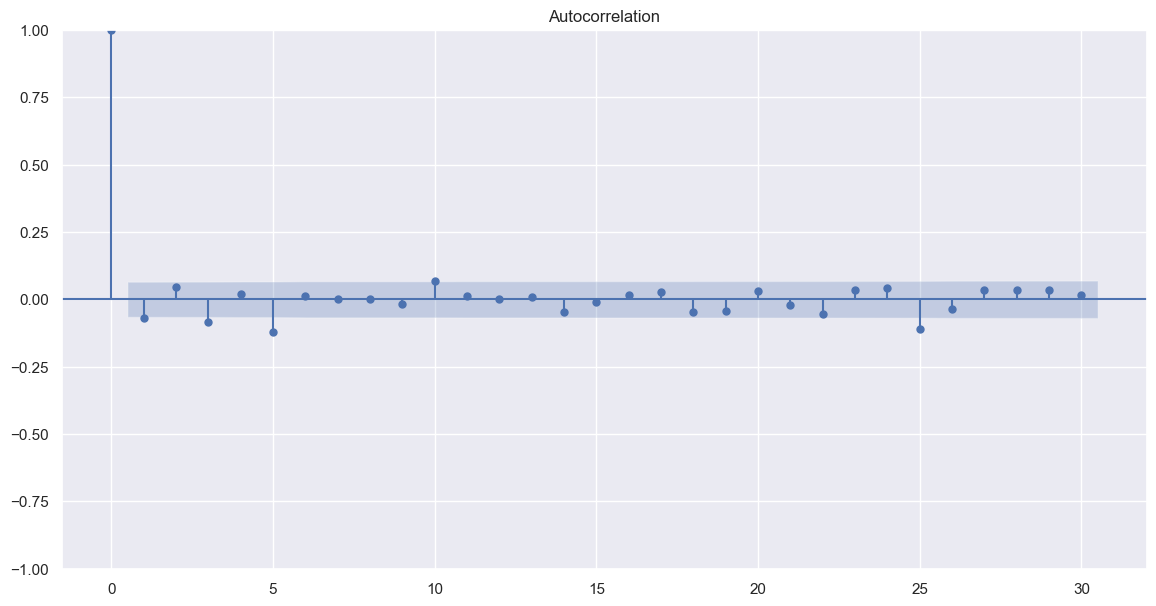

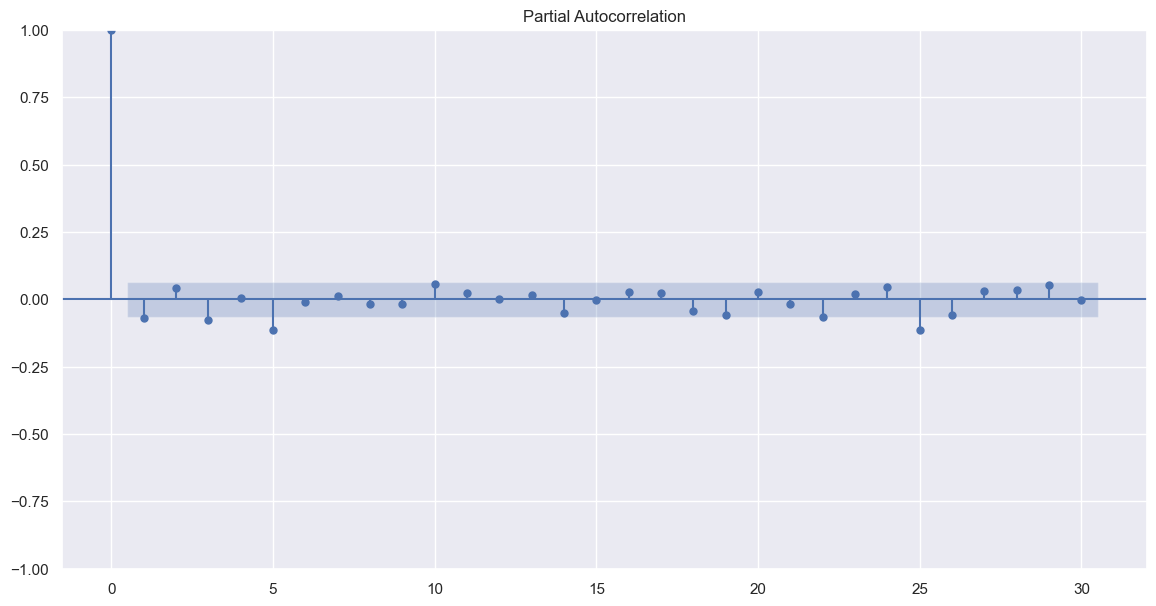

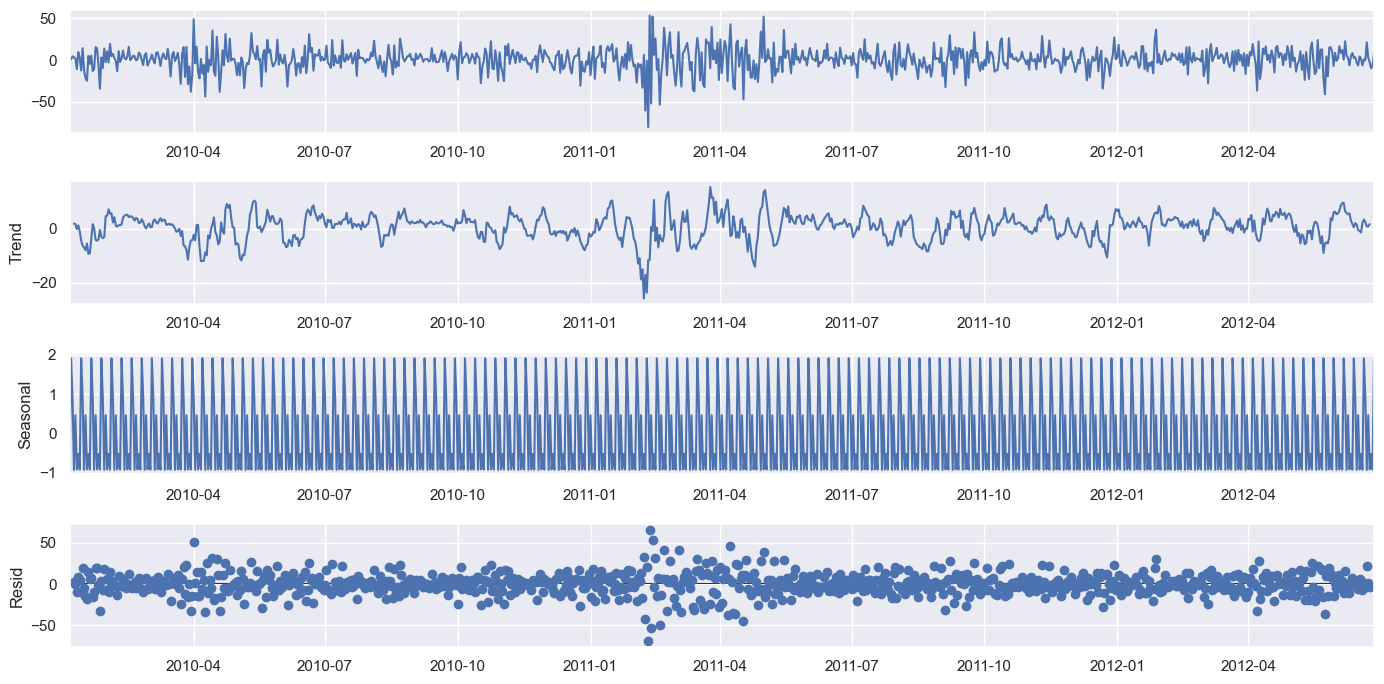

-15.547624375682693
2.119933509283535e-28


In [120]:
# EDA
f.plot_acf()
plt.show()
f.plot_pacf()
plt.show()
f.seasonal_decompose().plot()
plt.show()
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print(stat)
print(pval)

# Forecasting

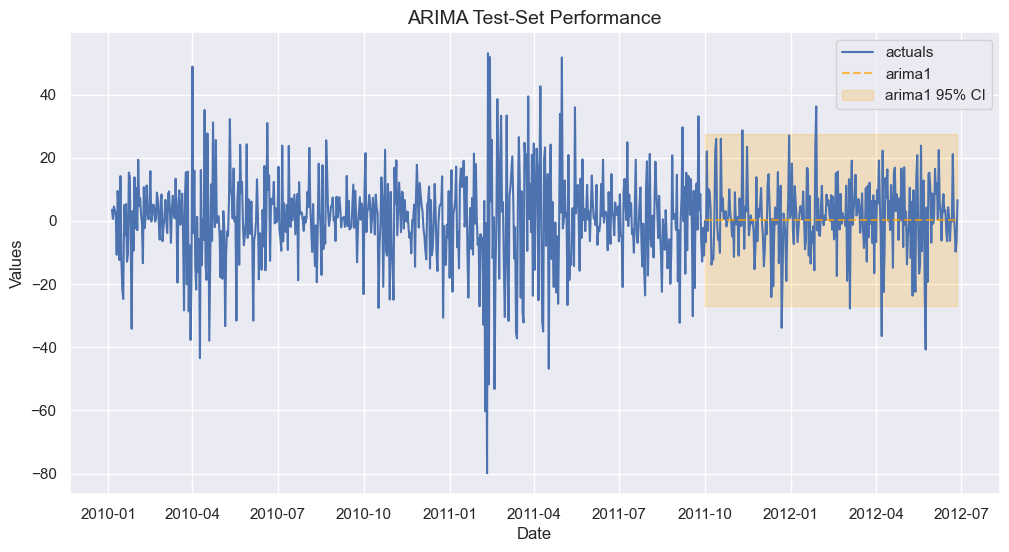

In [121]:
f.generate_future_dates(100) # 12-month forecast horizon
f.set_test_length(.3) # 20% test set
f.set_estimator('arima') # set arima
f.manual_forecast(call_me = 'arima1') # forecast with arima

f.plot_test_set(ci = True) # view test results
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

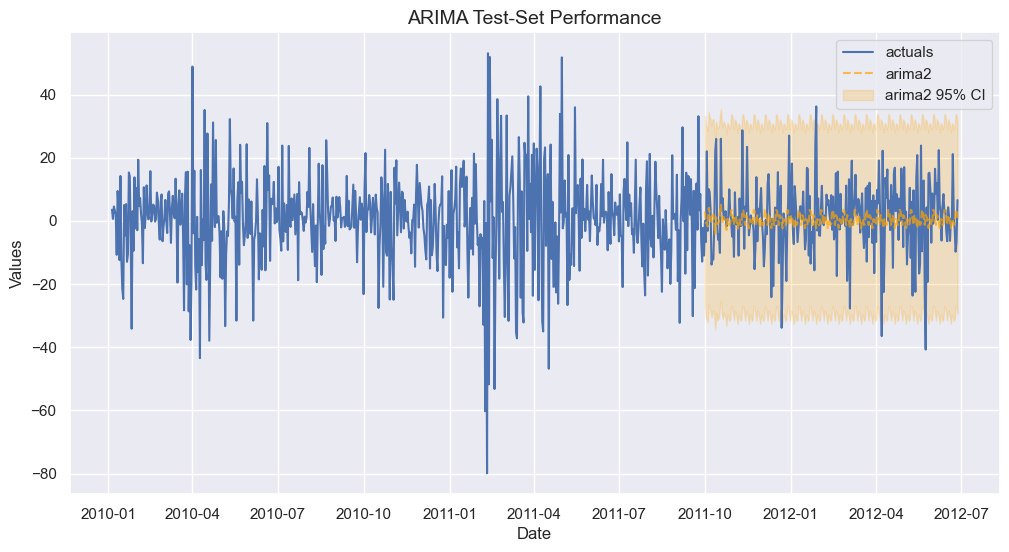

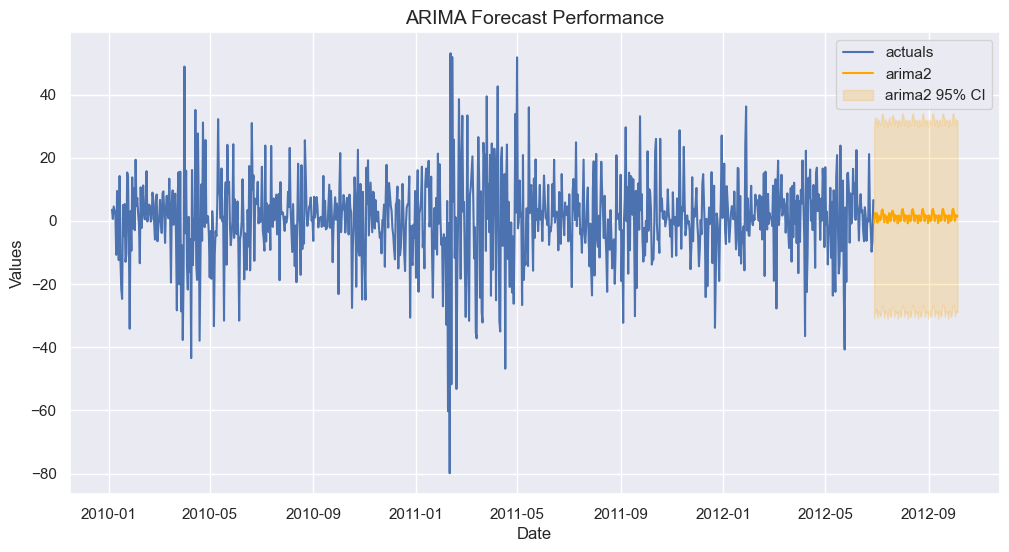

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                  905
Model:             ARIMA(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood               -3632.563
Date:                          Tue, 15 Aug 2023   AIC                           7279.126
Time:                                  13:17:33   BIC                           7312.680
Sample:                                       0   HQIC                          7291.949
                                          - 905                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0627      0.027     -2.280      0.023      -0.117      -0.009
ar.L2          0.0499      0.023      2.177      0.030       0.005       0.095
ma.L1         -0.9997      0.139     -7.184      0.000      -1.272      -0.727
ar.S.L12       0.0061      0.030      0.202      0.840      -0.053       0.066
ar.S.L24       0.0485      0.035      1.394      0.163      -0.020       0.117
ma.S.L12      -0.9976      0.191     -5.229      0.000      -1.371      -0.624
sigma2       188.3389     44.934      4.191      0.000     100.269     276.409
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               253.20
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -0.28
Prob(H) (two-sided):                  0.30   Kurtosis:                         5.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [122]:
# Forecast
f.manual_forecast(order=(2,1,1),seasonal_order=(2,1,1,12),call_me='arima2')

# View test results
f.plot_test_set(ci=True,models='arima2')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

# View forecast results
f.plot(ci=True,models='arima2')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

# See summary stats
f.regr.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=5206.432, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5209.333, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=5209.414, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=5209.814, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5207.652, Time=0.00 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=5204.588, Time=0.39 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=5202.617, Time=0.15 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=5204.585, Time=0.51 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=5200.975, Time=0.09 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=5202.941, Time=0.37 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=5202.945, Time=0.33 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=5204.803, Time=0.54 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=5207.815, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=5207.416, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0

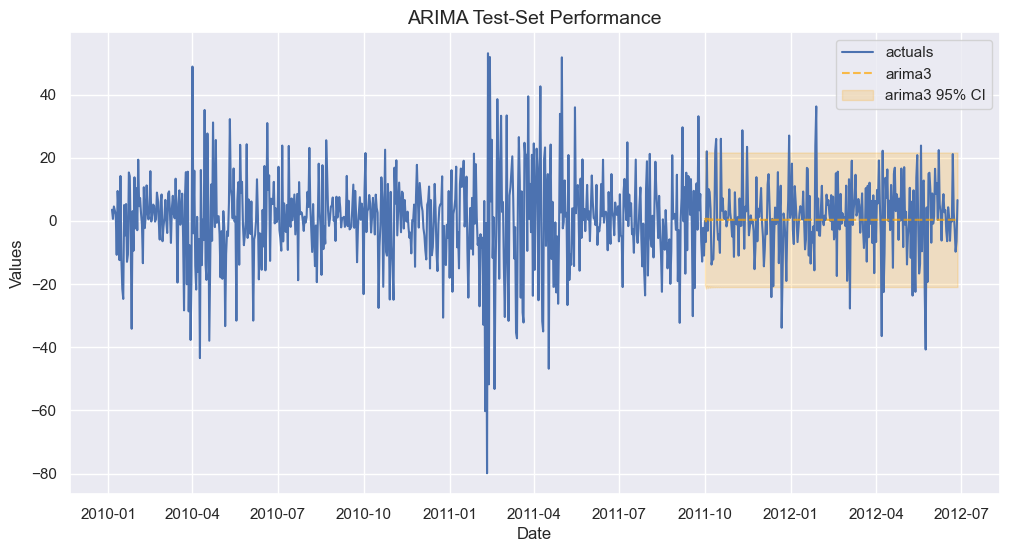

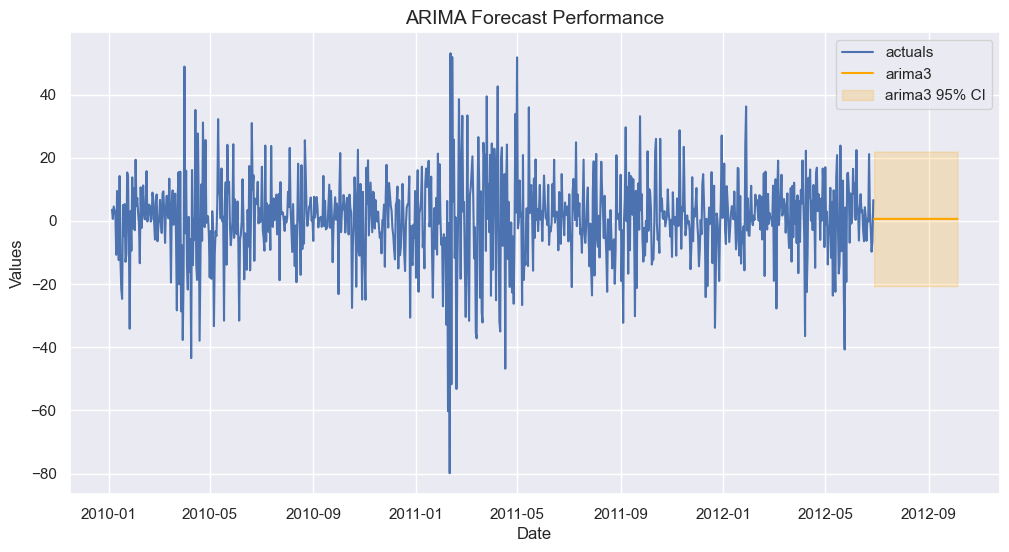

In [123]:
from scalecast.auxmodels import auto_arima

auto_arima(
    f,
    start_P = 1,
    start_q = 1,
    max_p = 6,
    max_q = 6,
    m = 12,
    seasonal = True,
    max_P = 2, 
    max_D = 2,
    max_Q = 2,
    max_d = 2,
    trace = True,
    error_action = 'ignore',
    suppress_warnings = True,
    stepwise = True,
    information_criterion = "aic",
    alpha=0.05,
    scoring='mse',
    call_me='arima3',
)

f.plot_test_set(ci=True,models='arima3')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

f.plot(ci=True,models='arima3')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

In [124]:
f.regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  905
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -3648.686
Date:                Tue, 15 Aug 2023   AIC                           7305.371
Time:                        13:17:38   BIC                           7324.603
Sample:                             0   HQIC                          7312.716
                                - 905                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6235      0.448      1.392      0.164      -0.255       1.502
ar.L1         -0.8359      0.071    -11.854      0.000      -0.974      -0.698
ma.L1          0.7715      0.083      9.335      0.000       0.610       0.933
sigma2       185.9507      6.178     30.097      0.000     173.841     198.060
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               257.56
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.42
Prob(H) (two-sided):                  0.23   Kurtosis:                         5.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

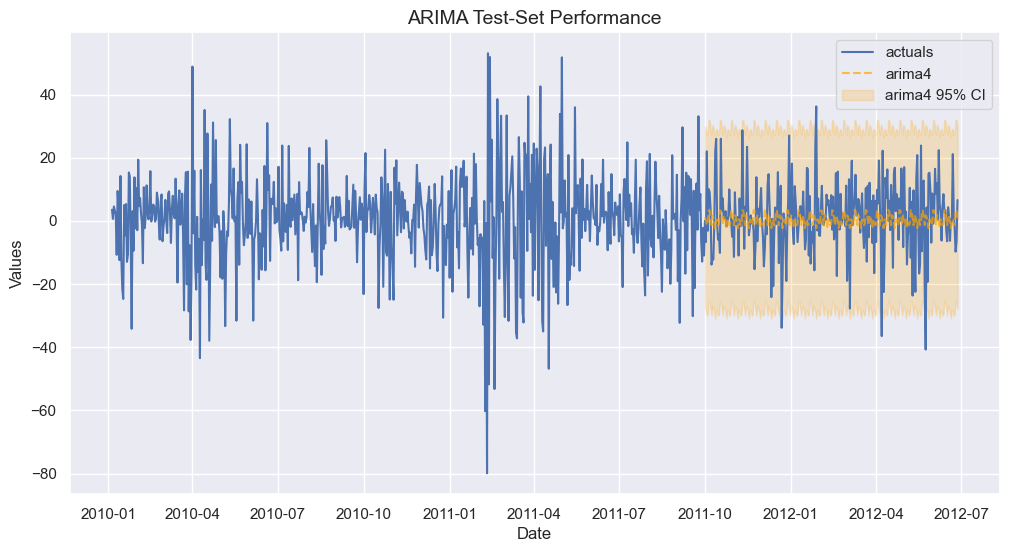

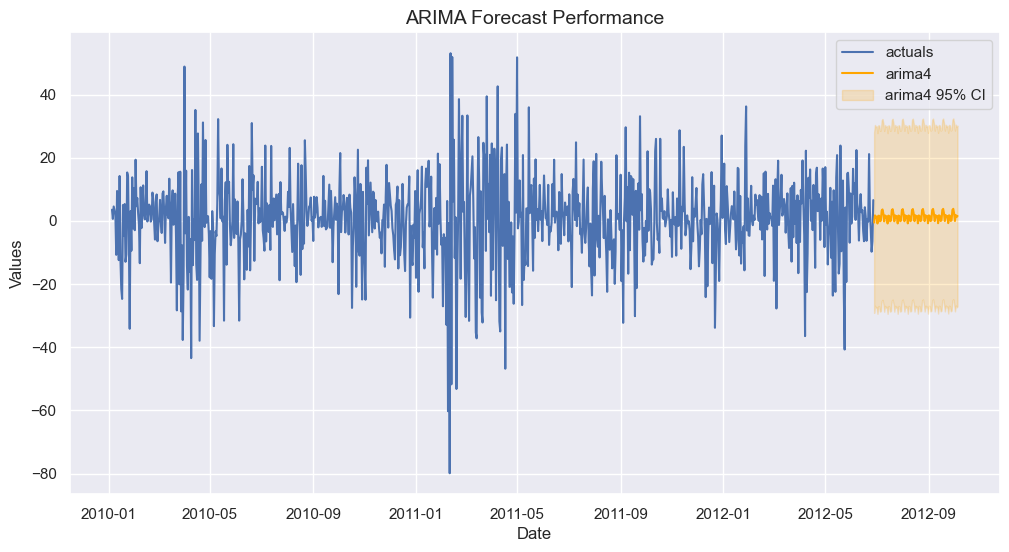

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                  905
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3634.478
Date:                          Tue, 15 Aug 2023   AIC                           7278.956
Time:                                  13:18:00   BIC                           7302.923
Sample:                                       0   HQIC                          7288.116
                                          - 905                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0700      0.026     -2.675      0.007      -0.121      -0.019
ma.L1         -0.9999      0.417     -2.396      0.017      -1.818      -0.182
ar.S.L12       0.0068      0.030      0.229      0.819      -0.052       0.065
ma.S.L12      -0.9999      3.093     -0.323      0.746      -7.062       5.062
sigma2       188.4209    597.045      0.316      0.752    -981.766    1358.607
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               303.59
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -0.32
Prob(H) (two-sided):                  0.30   Kurtosis:                         5.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [125]:
f.set_validation_length(12)
grid = {
    'order':[(1,1,1),(1,1,0),(0,1,1)],
    'seasonal_order':[(2,1,1,12),(1,1,1,12),(2,1,0,12),(0,1,0,12)]
}

f.ingest_grid(grid)
f.tune()
f.auto_forecast(call_me='arima4')

f.plot_test_set(ci=True,models='arima4')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

f.plot(ci=True,models='arima4')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

f.regr.summary()

In [126]:
pd.options.display.max_colwidth = 100
a = f.export('lvl_fcsts')
results = f.export(to_excel=True,
                   excel_name='arima_results.xlsx',
                   determine_best_by='TestSetMAPE')

In [129]:
a

,DATE,arima3,arima1,arima2,arima4
0,2012-06-28,0.540155,0.62374,-0.524201,-0.532344
1,2012-06-29,0.693195,0.62374,2.467882,1.734847
2,2012-06-30,0.565271,0.62374,1.002632,1.073684
3,2012-07-01,0.672201,0.62374,2.415042,1.349130
4,2012-07-02,0.582819,0.62374,-0.536195,-0.839539
...,...,...,...,...,...
95,2012-10-01,0.623515,0.62374,2.346629,2.328887
96,2012-10-02,0.623515,0.62374,-0.037033,-0.042252
97,2012-10-03,0.623515,0.62374,1.870474,1.833687
98,2012-10-04,0.623515,0.62374,1.230244,1.211286


# Result back conversion

In [130]:
special_data['Price']

new_date
2010-01-04 07:00:00    1132.99
2010-01-05 07:00:00    1136.52
2010-01-06 07:00:00    1137.14
2010-01-07 07:00:00    1141.69
2010-01-08 07:00:00    1144.98
                        ...   
2012-10-01 07:00:00    1833.32
2012-10-02 07:00:00    1842.02
2012-10-03 07:00:00    1841.40
2012-10-04 07:00:00    1841.07
2012-10-05 07:00:00    1848.36
Name: Price, Length: 1006, dtype: float64

In [133]:
special_data['Price']["2012-06-27 07:00:00"]

1697.48

In [135]:
import numpy as np
result_list = []
for i in range(4):
    temp_result = [special_data['Price']["2012-06-27 07:00:00"]]
    temp_result.extend(a['arima' + str(i+1)])
    temp_result = np.array(temp_result)
    temp_result = temp_result.cumsum()
    result_list.append(temp_result[1:])
result1 = [for_rediff]
result1.extend(a['arima1'].values.tolist())
result2 = np.array([for_rediff].append(a['arima2']))
result3 = np.array([for_rediff].append(a['arima3']))
result4 = np.array([for_rediff].append(a['arima4']))

In [136]:
len(special_data['Price'])

1006

In [137]:
len(date_rng)

1006

In [138]:
special_data['Price']

new_date
2010-01-04 07:00:00    1132.99
2010-01-05 07:00:00    1136.52
2010-01-06 07:00:00    1137.14
2010-01-07 07:00:00    1141.69
2010-01-08 07:00:00    1144.98
                        ...   
2012-10-01 07:00:00    1833.32
2012-10-02 07:00:00    1842.02
2012-10-03 07:00:00    1841.40
2012-10-04 07:00:00    1841.07
2012-10-05 07:00:00    1848.36
Name: Price, Length: 1006, dtype: float64

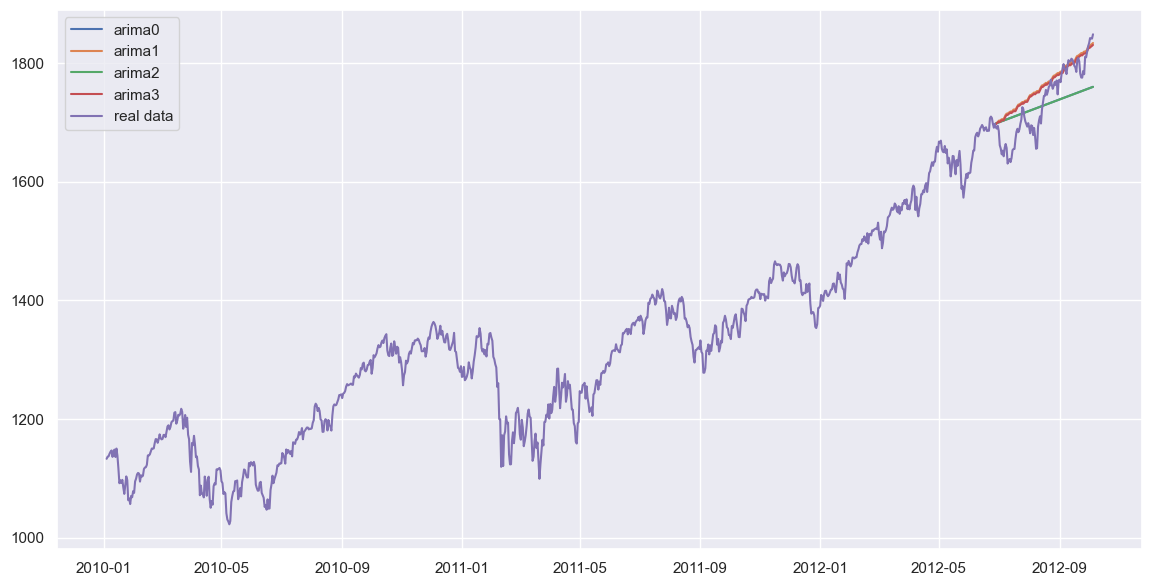

In [139]:
# Recreate a DatetimeIndex with a specific frequency
start_date = '2010-01-04'
end_date = '2012-10-05'
freq = 'D'  # Monthly frequency

date_rng = pd.date_range(start=start_date, end=end_date, freq=freq)
for i in range(4):
    plt.plot(a["DATE"].values, result_list[i], label = ('arima'+str(i)))
plt.plot(date_rng, special_data['Price'], label = "real data")
plt.legend()

In [26]:
summaries = results['model_summaries']
summaries[
    [
         'ModelNickname',
         'HyperParams',
         'InSampleMAPE',
         'TestSetMAPE'
    ]
]

,ModelNickname,HyperParams,InSampleMAPE,TestSetMAPE
0,arima2,"{'order': (2, 1, 1), 'seasonal_order': (2, 1, 1, 12)}",0.009163,0.037620
1,arima4,"{'order': (1, 1, 1), 'seasonal_order': (2, 1, 0, 12)}",0.010164,0.053786
2,arima3,"{'order': (1, 1, 1), 'seasonal_order': (0, 0, 0, 12), 'trend': None}",0.008407,0.068865
3,arima1,{},0.117585,0.237339


In [29]:
# Get the forecasted values and dates from the results attribute
forecast_dates = f
forecast_values = f.results['forecast']

AttributeError: 'Forecaster' object has no attribute 'results'

In [28]:
# Get the forecasted values as a DataFrame
forecast_results = pd.DataFrame({
    'Date': f.forecast_dates,
    'Forecast': f.forecast_values
})

# Save the forecasted values to CSV file
forecast_results.to_csv('forecast_results.csv', index=False)

AttributeError: 'Forecaster' object has no attribute 'forecast_dates'